# Evaluate Models
* In this notebooks we'll implement the inference and post inference part of the pipeline. 
* Along with that we'll also try and implement functions to validate the predictions visually. 

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-11-03 10:54:53.613890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762196093.635962  274866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762196093.642445  274866 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762196093.665010  274866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762196093.665038  274866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762196093.665039  274866 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1


## Constants

In [2]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Import Scripts

In [3]:
import os
import sys
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import graph_compatible_data_generator
from src import training_utils as tu

## logic to auto reload scripts without restarting the kernel
%load_ext autoreload
%autoreload 2

I0000 00:00:1762196097.546771  274866 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5851 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2e:00.0, compute capability: 7.5


## Test Data Pipeline

In [4]:
_, (x_test, y_test) = mnist.load_data()

X_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
# X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

batch_size = 32
raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# create a generator for 2 digits
data_gen_2_digits = graph_compatible_data_generator.create_data_generator(2)
data_gen_3_digits = graph_compatible_data_generator.create_data_generator(3)
data_gen_4_digits = graph_compatible_data_generator.create_data_generator(4)
data_gen_5_digits = graph_compatible_data_generator.create_data_generator(5)

In [5]:
processed_test_dataset_2 = raw_dataset.map(
    data_gen_2_digits).map(lambda canvas,prediction: canvas).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

--- Loading and caching MNIST data... ---


## Model Inference

### Load Model

In [6]:
model_name = "experiment_1_01.keras"

model = tf.keras.models.load_model(Path(models_dir, model_name), custom_objects={
                                   "calculate_model_loss": tu.calculate_model_loss, "objectness_metrics": tu.objectness_metrics, "bounding_box_metrics": tu.bounding_box_metrics, "classification_metrics": tu.classification_metrics})
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 100, 100, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 100, 100, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 100, 100, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 100, 100, 8)      │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 50, 50, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 50, 50, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 50, 50, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 25, 25, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 25, 25, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 25, 25, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 12, 12, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 12, 12, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 6, 6, 45)         │         1,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,537 (256.01 KB)

 Trainable params: 21,845 (85.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,692 (170.68 KB)

### Prediction

In [7]:
processed_test_dataset_2 = raw_dataset.map(
    data_gen_2_digits).map(lambda canvas,prediction: canvas).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

prediction = model.predict(processed_test_dataset_2)



I0000 00:00:1762196118.871253  275199 service.cc:152] XLA service 0x7f5b58003020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762196118.871336  275199 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-11-03 10:55:18.880767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762196118.925872  275199 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-03 10:55:19.571108: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.330, f32[8,8,3,3]{3,2,1,0} %bitcast.337, f32[8]{0} %bitcast.339), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

  5/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step 

I0000 00:00:1762196119.950570  275199 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

2025-11-03 10:55:54.150105: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[16,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,8,50,50]{3,2,1,0} %bitcast.330, f32[8,8,3,3]{3,2,1,0} %bitcast.337, f32[8]{0} %bitcast.339), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_20_1/convolution" source_file="/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-11-03 10:55:54.181529: I external/local_xla/xla/service/gpu/autotuning/conv_algori

313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step


In [8]:
prediction.shape

(10000, 6, 6, 45)

In [24]:
## inspecting single prediction
single_pred = prediction[:1,...]
single_pred = tf.reshape(single_pred,shape=(-1,6,6,3, 15))
tf.sigmoid(single_pred[0,0,0,0])


<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.03440223, 0.36280867, 0.49057806, 0.64866465, 0.35762647,
       0.3127348 , 0.9505042 , 0.14028756, 0.02720931, 0.39605358,
       0.14881112, 0.4256875 , 0.48824006, 0.17426611, 0.3819218 ],
      dtype=float32)>

## Post Processing
* In this step, we are going to post process the predictions to select the best anchor boxes from all the predictions
* To do this we'll,
    * Reshape it to easily access the `15` features that the model predicts,
    * Apply `tf.sigmoid` to the objectness score of the boxes and discard any boxes that are below the threshold.
    * Decode the coordinates returned by remaining boxes and apply Non-Max Suppresion (NMS) algorithm on it. 
* 

In [9]:
def reshape_prediction(prediction_object):
    prediction_shape = tf.shape(prediction_object)
    batch_size = prediction_shape[0]
    grid_width = prediction_shape[1]
    grid_height = prediction_shape[2]
    reshaped_prediction = tf.reshape(prediction_object, shape=(batch_size,grid_width,grid_height,-1,15))
    return reshaped_prediction

### Map Sigmoid Function - Confidence Scores


In [10]:
def map_confidence_score(prediction_object):
    ## objectness is the first flag in last axis
    confidence_score = tf.sigmoid(prediction_object[...,0])    
    return confidence_score


### Post Process Predictions

In [85]:
confidence_score_threshold = tf.constant(0.5, dtype=tf.float32)

@tf.function
def _process_single_prediction_image(prediction_image):
    # tf.print("prediction_image shape : ", tf.shape(prediction_image))
    image_shape = tf.shape(prediction_image)
    grid_width = tf.cast(image_shape[0], dtype=tf.float32)
    grid_height = tf.cast(image_shape[1], dtype=tf.float32)
    
    # step 0: normalize image
    normalized_image = tf.sigmoid(prediction_image[...,:5])
    # print("normalized image shape : ", tf.shape(normalized_image))
    # step 1: calculate confidence score
    confidence_scores = normalized_image[..., 0]
    # tf.print("confidence_scores shape : ", tf.shape(confidence_scores))

    # step 2: create boolean mask based on confidence score
    confidence_score_mask = confidence_scores[...,:] > confidence_score_threshold
    # tf.print("confidence_score_mask ", tf.shape(confidence_score_mask))

    ## create coordinate grid to decode the grid coordinates
    gridx_coordinate_range = tf.range(grid_width, dtype=tf.float32) 
    gridy_coordinate_range = tf.range(grid_height, dtype=tf.float32)
    
    grid_y,grid_x = tf.meshgrid(gridy_coordinate_range,gridx_coordinate_range, indexing="ij")
    image_grid = tf.stack(values=[grid_y,grid_x],axis=-1)
    image_grid = image_grid[:,:, tf.newaxis,:]    
    
    ## decode the coordinates    
    # Get the offsets and apply sigmoid
    x_offset = normalized_image[..., 1]
    y_offset = normalized_image[..., 2]

    # Get the grid indices (notice the swapped 0 and 1!)
    grid_x_index = image_grid[..., 1]
    grid_y_index = image_grid[..., 0]

    # 3. Apply the correct formula
    decoded_x_norm = (grid_x_index + x_offset) / grid_width
    decoded_y_norm = (grid_y_index + y_offset) / grid_height
    
    width = normalized_image[..., 3] 
    height = normalized_image[..., 4]
    decoded_box = tf.stack([decoded_x_norm,decoded_y_norm,width,height],axis = -1)
        
    ## decode class
    class_scores = tf.nn.softmax(prediction_image[..., 5:],axis=-1)
        
    ## decoded prediction
    confidence_scores = confidence_scores[:,:,:,tf.newaxis]
    decoded_prediction = tf.concat([confidence_scores,decoded_box,class_scores],axis=-1)
    

    # # step 3: filter boxes based on the mask
    filtered_boxes = tf.boolean_mask(
        decoded_prediction, confidence_score_mask)
    # tf.print("filtered_boxes : ", tf.shape(filtered_boxes))
    
    # step 4: filter scores based on the mask
    filtered_scores = filtered_boxes[:,0]
    # tf.print("filtered_scores : ", tf.shape(filtered_scores))

    # step 5: read and decode the values for NMS algorithm
    # prediction object flag, x_center, y_center, width, height, one hot encoded class values (0 to 9)
    x_center = filtered_boxes[..., 1] * 100
    y_center = filtered_boxes[..., 2] * 100
    width = filtered_boxes[..., 3] * 100
    height = filtered_boxes[..., 4] * 100

    # calculate min and max values
    x_min = tf.floor(x_center - (width / 2))
    x_max = tf.floor(x_center + (width / 2))
    y_min = tf.floor(y_center - (height / 2))
    y_max = tf.floor(y_center + (height / 2))

    boxes = tf.stack([y_min,x_min,y_max,x_max],axis=1)
    # tf.print("boxes shape : ", tf.shape(boxes))

    # step 5: perform NMLS
    nms_indices = tf.image.non_max_suppression(boxes=boxes,scores=filtered_scores,max_output_size=5)
    # tf.print("nms_indices : ", nms_indices)
    
    # step 6: Final boxes
    final_boxes = tf.gather(filtered_boxes, nms_indices)
    # tf.print("final_boxes.shape : ", tf.shape(final_boxes))

    return final_boxes

@tf.function
def post_process(predictions):
    # step 1: reshape predictions
    reshaped_prediction = reshape_prediction(predictions)
    # tf.print("reshaped_prediction shape : ", tf.shape(reshaped_prediction))

    # step 2: loop through the predictions and apply NMS to each prediction
    spec_final_data = tf.RaggedTensorSpec(
        shape=(None,15), dtype=tf.float32, ragged_rank=0)

    final_predictions = tf.map_fn(
        _process_single_prediction_image, reshaped_prediction, parallel_iterations=20, fn_output_signature=spec_final_data)


    return final_predictions

# top_10_predictions = prediction[:10,...]
# output = post_process(predictions=top_10_predictions)
# tf.print("output shape : ", tf.shape(output))

## Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Class : 7, Probability : 1.4780149459838867
Class : 4, Probability : 23.57710075378418
Class : 4, Probability : 11.955872535705566
Class : 7, Probability : 2.1330137252807617
Class : 7, Probability : 0.2953225374221802


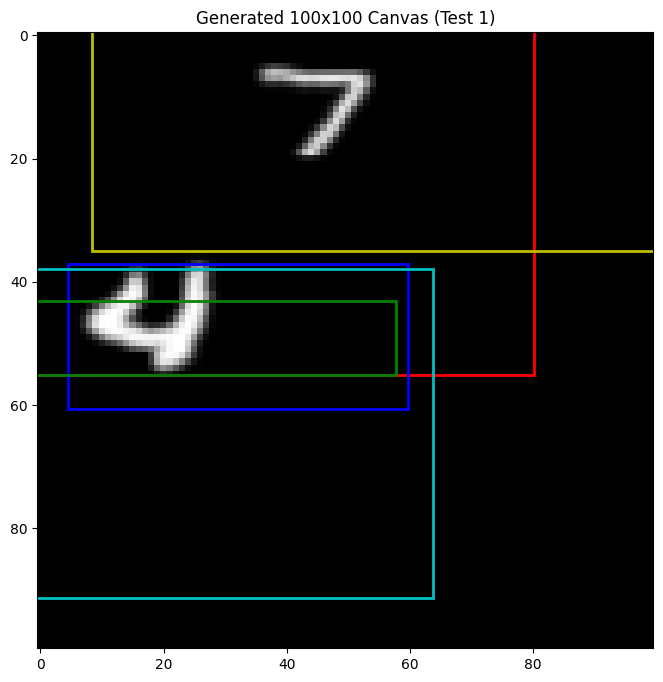

In [97]:
def visualize_generated_data(canvas, predictions):
    # batched_canvases,predictions = batch
    # print(f"batched_canvases shape: {canvas.shape}")
    # print(f"predictions shape ", tf.shape(predictions))
    # Get the very first canvas from the batch (shape 100x100)
    # We use .numpy() to convert it from a EagerTensor to a NumPy array for plotting
    canvas_to_show = canvas[0].numpy()
    prediction = predictions[0]

    # print(f"Canvas shape: {canvas_to_show.shape}")
    # print(f"Single Prediction shape: {prediction.shape}")
    prediction_boxes = prediction.shape[0]
    
    
    # # Plot it
    # # --- Create a figure and axis ---
    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    colors = ['r','b','g','y','c']
    
    # get the 2 predictions
    for i in range(prediction_boxes):
        bbox = (prediction[i]).numpy() * 100
        
        # flag, x_center, y_center, width, height,
        flag = bbox[0]
        x_center = bbox[1]
        y_center = bbox[2]
        width = bbox[3]
        height = bbox[4]
        pred_class = np.argmax(bbox[5:])
        pred_probability = bbox[pred_class]
        
        
        print(f"Class : {pred_class}, Probability : {pred_probability}")
        
        x_min = x_center - (width / 2)
        y_min = y_center - (height / 2)        
        # print("flag, x_center, y_center, width, height",flag, x_min, y_min, width, height,)
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor=colors[i],
            facecolor='none'
        )
        
        ax.add_patch(rect)
    # Display the image
    ax.imshow(canvas_to_show, cmap='gray')
    
    
    plt.title("Generated 100x100 Canvas (Test 1)")
    plt.show()


# Get one batch
# Your dataset is batched, so .take(1) gets one full batch
for canvas in processed_test_dataset_2.take(1):
    # visualize_generated_data(batch=batch)
    predictions = model.predict(canvas)
    # tf.print("prediction.shape ", tf.shape(prediction))
    post_procesed_data = post_process(predictions=predictions)
    # tf.print("post_procesed_data.shape ", tf.shape(post_procesed_data))
    visualize_generated_data(canvas, post_procesed_data)
    